In [1]:
import math
import cv2
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

In [2]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence = 0.3, model_complexity = 2)
mp_drawing = mp.solutions.drawing_utils

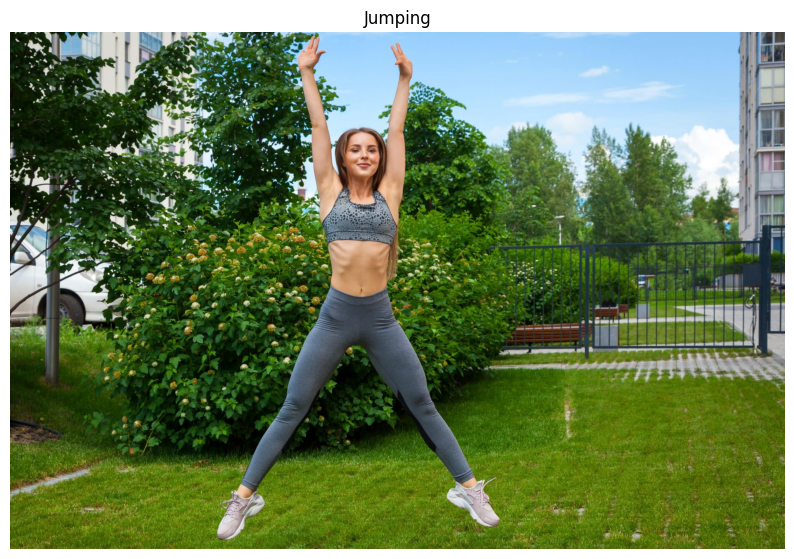

In [3]:
sample_img = cv2.imread("jumping.jpg")
plt.figure(figsize = [10,10])
plt.title("Jumping");plt.axis("off")
plt.imshow(sample_img[:,:,::-1]);

In [4]:
result = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
if result.pose_landmarks:
  for i in range(2):
    print(f"{mp_pose.PoseLandmark(i).name}:\n{result.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}")

NOSE:
x: 0.4565827
y: 0.24259977
z: -0.3237193
visibility: 0.99957305

LEFT_EYE_INNER:
x: 0.4618083
y: 0.2290228
z: -0.30206427
visibility: 0.9990237



In [5]:
image_height, image_width, _ = sample_img.shape

# Check if landmarks are detected
if result.pose_landmarks:
    for i in range(2):
        landmark = result.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]

        print(f"{mp_pose.PoseLandmark(i).name}:")
        print(f"x: {landmark.x * image_width}")
        print(f"y: {landmark.y * image_height}")
        print(f"z: {landmark.z * image_width}")
        print(f"visibility: {landmark.visibility}")

NOSE:
x: 1168.8516998291016
y: 414.11780811846256
z: -828.7213897705078
visibility: 0.9995730519294739
LEFT_EYE_INNER:
x: 1182.229232788086
y: 390.9419211745262
z: -773.2845306396484
visibility: 0.9990236759185791


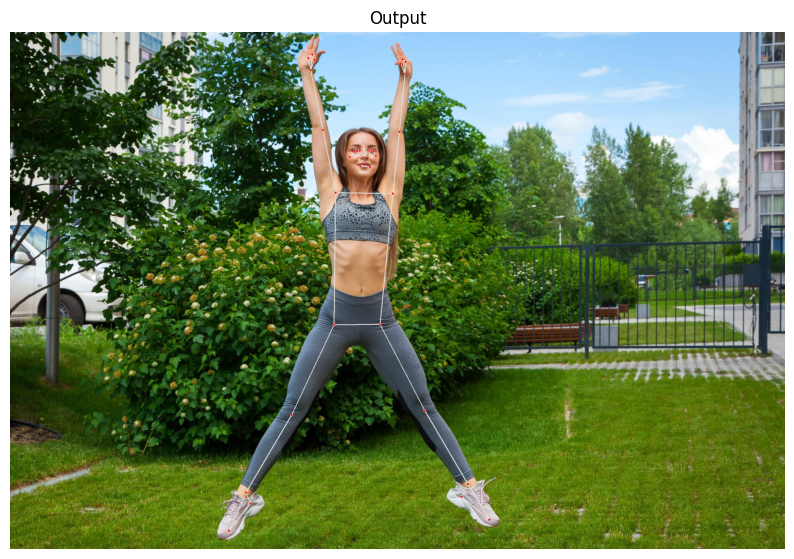

In [6]:
img_copy = sample_img.copy()

if result.pose_landmarks:
  mp_drawing.draw_landmarks(image=img_copy, landmark_list=result.pose_landmarks, connections = mp_pose.POSE_CONNECTIONS)
  fig = plt.figure(figsize=[10,10])
  plt.title("Output");plt.axis("off");plt.imshow(img_copy[:,:,::-1]);

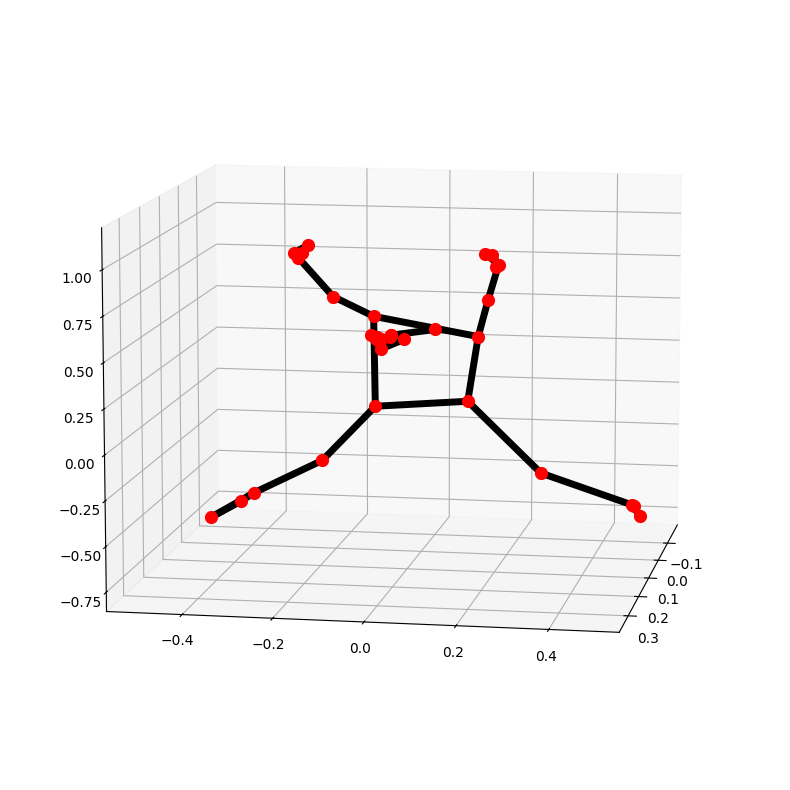

In [8]:
mp_drawing.plot_landmarks(result.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

## `Create a Pose Detection Function`

In [9]:
def detectPose(image, popse, display=True):
  output_image = image.copy()
  imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  result = pose.process(imageRGB)
  height, width, _ = image.shape
  landmarks = []
  if result.pose_landmarks:
    mp_drawing.draw_landmarks(image=output_image, landmark_list=result.pose_landmarks, 
                              connections = mp_pose.POSE_CONNECTIONS)
    for landmark in result.pose_landmarks.landmark:
      landmarks.append((int(landmark.x * width), int(landmark.y*height),
                        (landmark.z * width)))
  if display:
    plt.figure(figsize=[15,15])
    plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis("off")
    plt.subplot(121);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis("off")
    mp_drawing.plot_landmarks(result.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

  else:
    return output_image, landmarks

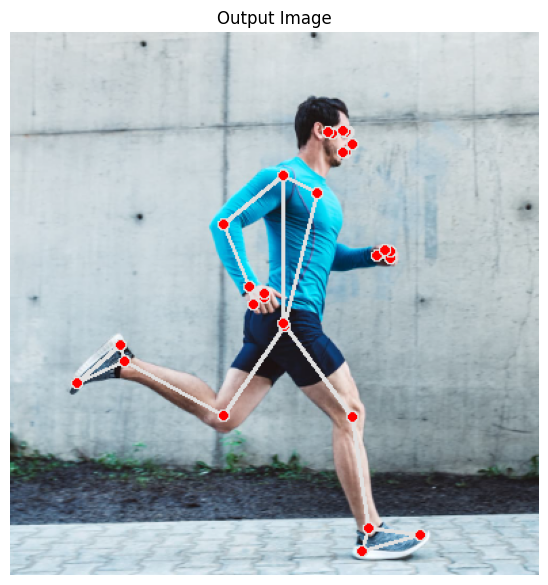

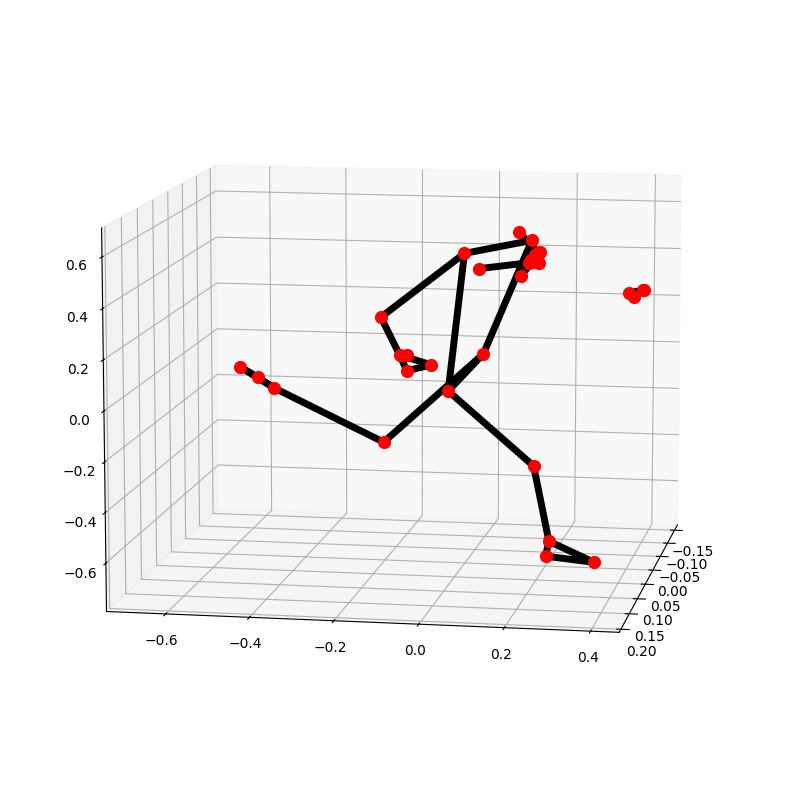

In [10]:
image = cv2.imread("running.png")
detectPose(image, pose, display=True)

In [12]:
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)
video = cv2.VideoCapture(0)
cv2.namedWindow("Pose Detection", cv2.WINDOW_NORMAL)
video.set(3, 1280)
video.set(4, 960)

time1 = 0
while video.isOpened():
  ok, frame = video.read()
  if not ok:
    break
  frame = cv2.flip(frame, 1)
  frame_height, frame_width, _ = frame.shape
  frame = cv2.resize(frame, (int(frame_width *  (640 / frame_height)),640))
  frame, _ = detectPose(frame, pose_video, display=False)
  time2 = time()
  if(time2 - time1) > 0:
    frames_per_second = 1.0 / (time2-time1)
    cv2.putText(frame, "FPS: {}".format(int(frames_per_second)), (10,30), cv2.FONT_HERSHEY_PLAIN, 2, (0,255,0), 3)
  time1 = time2
  cv2.imshow("Pose Detection", frame)
  k = cv2.waitKey(1) & 0xFF
  if(k == 27):
    break
video.release()
cv2.destroyAllWindows()

## `Pose classify with angle heuristic`

In [13]:
def calculateAngle(landmark1, landmark2, landmark3):
    x1,y1,_ = landmark1
    x2,y2,_ = landmark2
    x3,y3,_ = landmark3
    
    angle = math.degrees(math.atan2(y3-y2, x3-x2) - math.atan2(y1-y2, x1-x2))
    if angle < 0:
        angle += 360
    return angle

In [14]:
angle = calculateAngle((558,326,0),(642,333,0),(718,321,0))
print(f"The Calculate angle is {angle}")

The Calculate angle is 166.26373169437744


## `Create a function to perfomr Pose Classification`
### `We have 3 following yoga poses`
- Warrior II Pose
- T Pose
- Tree Pose

In [18]:
def classifyPose(landmarks, output_image, display=False):
    label = "Unknown Pose"
    color = (0,0,255) # Red
# Calculate a required angle
# -------------------------------------------------------------
    left_elbow_angle = calculateAngle(landmark[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                    landmark[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                    landmark[mp_pose.PoseLandmark.LEFT_WRIST.value])

    right_elbow_angle = calculateAngle(landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                    landmark[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                    landmark[mp_pose.PoseLandmark.RIGHT_WRIST.value])

    left_shoulder_angle = calculateAngle(landmark[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                    landmark[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                    landmark[mp_pose.PoseLandmark.LEFT_HIP.value])

    right_shoulder_angle = calculateAngle(landmark[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                    landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                    landmark[mp_pose.PoseLandmark.RIGHT_ELBOW.value])
    
    left_knee_angle = calculateAngle(landmark[mp_pose.PoseLandmark.LEFT_HIP.value],
                                    landmark[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                    landmark[mp_pose.PoseLandmark.LEFT_ANKLE.value])
    
    right_knee_angle = calculateAngle(landmark[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                    landmark[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                    landmark[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    # Check if the both arms are straight
    if left_elbow_angle > 165 and left_elbow_angle<195 and right_elbow_angle>165 and right_elbow_angle<195:
        #Check if shoulders are at the required angle
        if left_shoulder_angle > 80 and left_shoulder_angle<110 and right_shoulder_angle>80 and right_shoulder_angle<110:
    # Check if it is the warrior II pose
    # ----------------------------------------------------------------------------------------------------------
            
            # Check if one leg is straight
            if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle > 165 and right_knee_angle <195:
                 # Check if the other leg is bended in a required angle
                if left_knee_angle > 90 and left_knee_angle<120 or right_knee_angle>90 and right_knee_angle < 120:
                    label = "Warrior II Pose"
            # Check if both leg are straight
            if left_knee_angle>160 and left_knee_angle<195 and right_knee_angle>160 and right_knee_angle<195:
                label = "T Pose"
    
    # Check if one leg is straight
    if left_knee_angle > 165 and left_knee_angle < 195 or right_knee_angle>165 and right_knee_angle<195:
        # Check if the other leg is bended at the requireed angle
        if left_knee_angle > 315 and left_knee_angle<335 or right_knee_angle>25 and right_knee_angle < 45:
            label = "Tree Pose"
            
    if label != "Unknown Pose":
        color= (0,255,0) #Green
        
    cv2.putText(output_image, label, (10,30), cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
    if display:
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis("off");
    else:
        return output_image, label

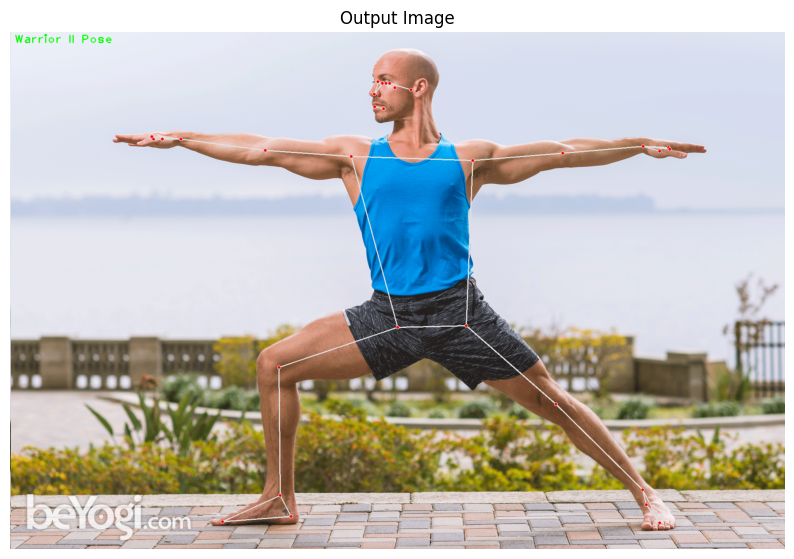

In [19]:
image = cv2.imread("Warrior-II-Pose.png")
output_image , landmark = detectPose(image, pose, display=False)
if landmark:
    classifyPose(landmark, output_image, display=True)